![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Finance/08.0.Answering_Questions_Financial_Texts.ipynb)

# Answering Questions on Financial Texts
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

> *While our gross profit margin increased to 81.4% in 2020 from 63.1% in 2019, our revenues declined approximately 27% in 2020...
...
We reported an operating loss of approxiamtely \$8,048,581 million in 2020 as compared to an operating loss of \$7,738,193 in 2019
...*




```
- What is the profit increase?
- What was the decline in revenue?
- What was the operation loss in 2020?
- What was the operation loss in 2019?
```

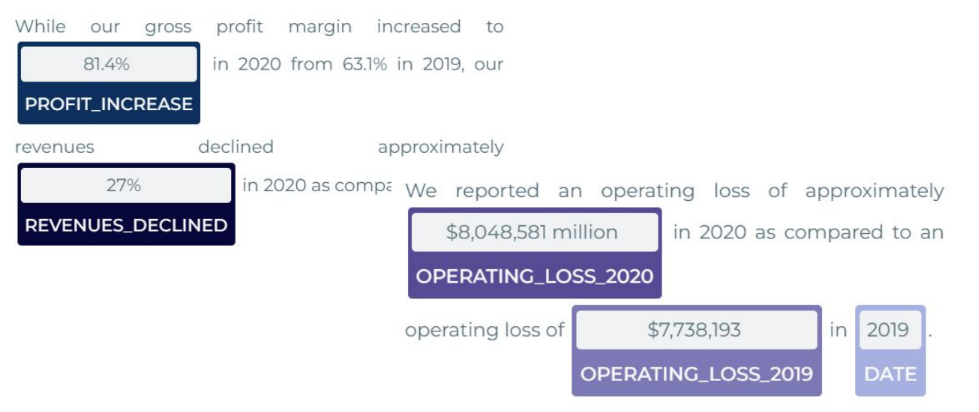



**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P. 


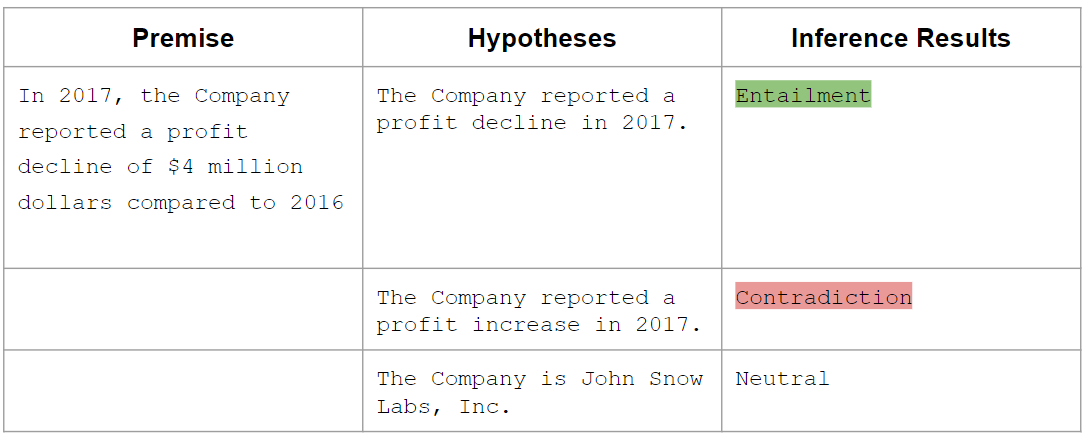

Although we are not getting into the maths of it, it's basically done by using a Language Model to encode P, H and then carry out sentence similarity operations.

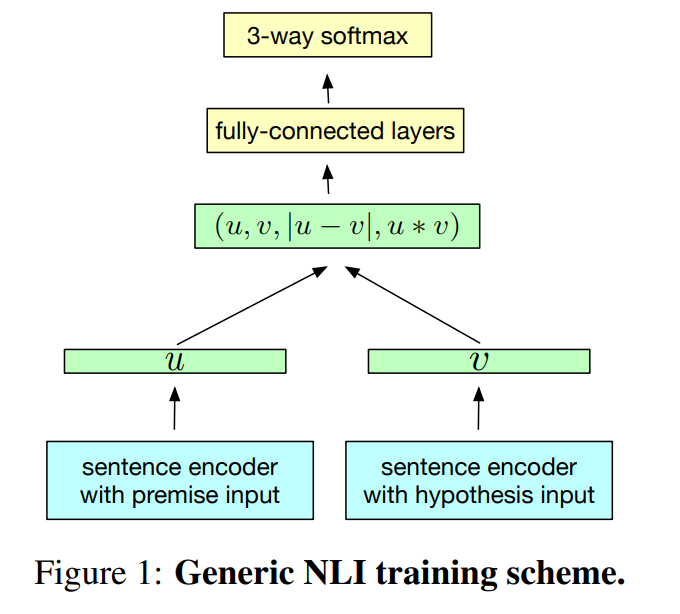

## Applications of NLI: The basics
The most straight-forward, retrieving answers to natural language questions.
  - Type 1: Open-book questions, where you give the text (P) to the model.
  - Type 2: Close-book questions, where you just use the pretrained Language Model capabilities, learn on texts during training time.

## Applications of NLI: Zero-shot
At John Snow Labs, we have developed our own annotators based on NLI, to not only carry out Question Answering, but using QA to:
- Retrieve Entities, also know as Zero-shot NER;
- Retrieve Relations, also known as Zero-shot Relation Extraction;

### How we achieve Zero-shot NER With QA?
Given a Question Q, for example, `What was the profit increase in 2017?`, and given the text P `In 2017, the Company reported a profit decline of $4 million dollars compared to 2016` we:

- Generate Hypotheses H with the tokens of the text
  - The profit increase in 2017 was 2017: `contradiction`
  - The profit increase in 2017 was Company: `contradiction`
  - The profit increase in 2017 was ...: `contradiction`
  - The profit increase in 2017 was $4: `entailment`
  - The profit increase in 2017 was million: `entailment`

- We check all the H towards P to see if they are `entailed`. If so, we return them as NER entity. If several tokens in a row return `entailed`, we check if they can be part of the same chunk.

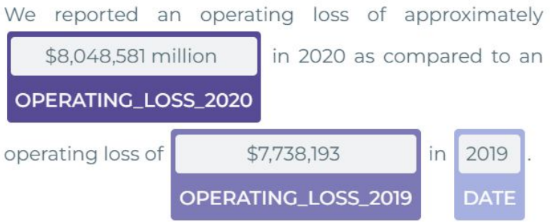

Let's take a look at some examples of applications of QA to Financial Texts.

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [2]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

# Open Book Questions

In [6]:
! wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/cdns-20220101.html.txt

--2023-01-23 18:57:07--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/cdns-20220101.html.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347392 (339K) [text/plain]
Saving to: ‘cdns-20220101.html.txt’

cdns-20220101.html. 100%[===================>] 339.25K  --.-KB/s    in 0.04s   

2023-01-23 18:57:07 (9.03 MB/s) - ‘cdns-20220101.html.txt’ saved [347392/347392]



In [7]:
with open('cdns-20220101.html.txt', 'r') as f:
  cadence_sec10k = f.read()

Let's take a random piece of text from our 10-K filing...

In [8]:
random_piece = cadence_sec10k[135000:144000]
print(random_piece)

necessary, on commercially reasonable terms or at all and, even if successful, those alternative actions may not allow us to meet our scheduled debt service obligations. The agreement governing our revolving credit facility restricts our ability to dispose of assets and use the proceeds from those dispositions and may also restrict our ability to raise debt or equity capital to be used to repay other indebtedness when it becomes due. We may not be able to consummate those dispositions or to obtain proceeds in an amount sufficient to meet any debt service obligations then due. 
In addition, we conduct a substantial portion of our operations through our subsidiaries, none of which are currently guarantors of our indebtedness. Accordingly, repayment of our indebtedness is dependent on the generation of cash flow by our subsidiaries and their ability to make such cash available to us, by dividend, debt repayment or otherwise. Our subsidiaries do not have any obligation to pay amounts due o

Items 2,3, and 5 seem good to ask questions about them!

In [9]:
item2 = """We own land and buildings at our headquarters located in San Jose, California. We also own buildings in India. As of January 1, 2022, the total square footage of our owned buildings was approximately 1,010,000.
We lease additional facilities in the United States and various other countries. We may sublease certain of these facilities where space is not fully utilized."""

item3 = """From time to time, we are involved in various disputes and legal proceedings that arise in the ordinary course of business. These include disputes and legal proceedings related to intellectual property, indemnification obligations, mergers and acquisitions, licensing, contracts, customers, products, distribution and other commercial arrangements and employee relations matters. At least quarterly, we review the status of each significant matter and assess its potential financial exposure. If the potential loss from any claim or legal proceeding is considered probable and the amount or the range of loss can be estimated, we accrue a liability for the estimated loss. Legal proceedings are subject to uncertainties, and the outcomes are difficult to predict. Because of such uncertainties, accruals are based on our judgments using the best information available at the time. As additional information becomes available, we reassess the potential liability related to pending claims and legal proceedings and may revise estimates."""

item5 = """Our common stock is traded on the Nasdaq Global Select Market under the symbol CDNS. As of February 5, 2022, we had 384 registered stockholders and approximately 340,000 beneficial owners of our common stock."""

## Let's create a pipeline
We will use a `RoBerta` based QA model named `finqa_roberta`


To do that, we use in our pipelines:
- a `MultiDocumentAssembler`, which puts together questions (Q to create H) and context (P).
- a BertForQuestionAnswering pretrained model. 

**IMPORTANT: We highly recommend to use `setCaseSensitive(False)` to prevent uppercase to be managed as proper nouns and possibly trigger OOV.**

In [10]:
documentAssembler = nlp.MultiDocumentAssembler()\
  .setInputCols(["question", "context"])\
  .setOutputCols(["document_question", "document_context"])

spanClassifier = nlp.BertForQuestionAnswering.pretrained("finqa_bert","en", "finance/models") \
  .setInputCols(["document_question", "document_context"]) \
  .setOutputCol("answer") \
  .setCaseSensitive(False)

qa_pipeline = nlp.Pipeline().setStages([
  documentAssembler,
  spanClassifier
])

finqa_bert download started this may take some time.
Approximate size to download 389 MB
[OK!]


In [11]:
P = item2

Q = [
     "Where are the headquarters?",
     "What is the total square footage?",
     "In which countries do they lease facilities?"
]

Q_P = [ [q, P] for q in Q]

example = spark.createDataFrame(Q_P).toDF("question", "context")

example.show()

+--------------------+--------------------+
|            question|             context|
+--------------------+--------------------+
|Where are the hea...|We own land and b...|
|What is the total...|We own land and b...|
|In which countrie...|We own land and b...|
+--------------------+--------------------+



In [12]:
result = qa_pipeline.fit(example).transform(example)

result.select('question', 'answer.result', 'answer').show(truncate=False)

+--------------------------------------------+-----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|question                                    |result                 |answer                                                                                                                                                                 |
+--------------------------------------------+-----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Where are the headquarters?                 |[San Jose , California]|[{chunk, 0, 20, San Jose , California, {chunk -> 0, start_score -> 0.8019189, score -> 0.83842176, end -> 20, start -> 17, end_score -> 0.8749246, sentence -> 0}, []}]|
|What is the total square footage?          

In [13]:
P = item5

Q = [
     "Where is their common stock traded?",
     "Which is the trading symbol?"
]

Q_P = [ [q, P] for q in Q]

example = spark.createDataFrame(Q_P).toDF("question", "context")

result = qa_pipeline.fit(example).transform(example)

result.select('question', 'answer.result', 'answer').show(truncate=False)

+-----------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|question                           |result                       |answer                                                                                                                                                                        |
+-----------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Where is their common stock traded?|[Nasdaq Global Select Market]|[{chunk, 0, 26, Nasdaq Global Select Market, {chunk -> 0, start_score -> 0.30269945, score -> 0.41721502, end -> 21, start -> 16, end_score -> 0.5317306, sentence -> 0}, []}]|
|Which is the trading symbol

In [14]:
P = item3

Q = [
     "What kind of disputes or legal proceedings related to?"
]

Q_P = [ [q, P] for q in Q]

example = spark.createDataFrame(Q_P).toDF("question", "context")

result = qa_pipeline.fit(example).transform(example)

result.select('question', 'answer.result', 'answer').show(truncate=False)

+------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|question                                              |result                                                                                                                                                                                                         |answer                                                                                                                

# Automatic Question Generation
Now the question is ... is there a way to generate the questions automatically?

The answer is simple: **YES**, there is!

We have several ways to generate a series of questions, given for examplee:
- A `SUBJECT` of a sentence;
- An `ACTION` (verb);

More specifically, there are three ways:
1. Using the grammatical information (Part of Speech and Dependency Tree);
2. Using NER / Contextual Parser or other method to retrieve SUBJECT and VERB

Check the notebook "Automatic Question Generation" for examples of how to do it.

# Table Question Answering
For table question answering we have a specific notebok you will find in this workshop. Feel free to check it out too!

But it the meantime, a small spoiler...

# 1. From csv files

Let's create a `csv` file with information about clients and agreements.

In [15]:
import pandas as pd

df_data = { 
    "header" : ['client name', 'last operation year', 'last operation amount', 'document'],
    "rows" : [    
 ['John Smith', '2007', '$200000', 'NDA'],
 ['Jack Gordon', '2017', '$10000',  'Credit Agreement'],
 ['Mary Lean', '2001', '$120000', 'License Agreement'],
 ['Jessica James', '2022', '$1200000', 'Purchase Agreement'],
]
}


df = pd.DataFrame(df_data['rows'], columns=df_data['header'])

df.to_csv('table.csv', index=False)


In [16]:
df_data

{'header': ['client name',
  'last operation year',
  'last operation amount',
  'document'],
 'rows': [['John Smith', '2007', '$200000', 'NDA'],
  ['Jack Gordon', '2017', '$10000', 'Credit Agreement'],
  ['Mary Lean', '2001', '$120000', 'License Agreement'],
  ['Jessica James', '2022', '$1200000', 'Purchase Agreement']]}

In [17]:
df

,client name,last operation year,last operation amount,document
0,John Smith,2007,$200000,NDA
1,Jack Gordon,2017,$10000,Credit Agreement
2,Mary Lean,2001,$120000,License Agreement
3,Jessica James,2022,$1200000,Purchase Agreement


In [18]:
import json
json.dumps(df_data)

'{"header": ["client name", "last operation year", "last operation amount", "document"], "rows": [["John Smith", "2007", "$200000", "NDA"], ["Jack Gordon", "2017", "$10000", "Credit Agreement"], ["Mary Lean", "2001", "$120000", "License Agreement"], ["Jessica James", "2022", "$1200000", "Purchase Agreement"]]}'

Now, some questions...

In [19]:
queries = [
    "Who signed an NDA?",
    "Who operated last time in 2022?", 
    "What is the total amount of operations?",
    "Which year a Credit Agreement was signed?",
]

Now, we will use the following specific components:
- A `MultiDocumentAssembler`, to put together the questions and the table in `json` format
- A `TableAssembler` to assemble the table from a json

In [20]:
data = spark.createDataFrame([
        [json.dumps(df_data), " ".join(queries)]
    ]).toDF("table_json", "questions")

In [21]:
data.show()

+--------------------+--------------------+
|          table_json|           questions|
+--------------------+--------------------+
|{"header": ["clie...|Who signed an NDA...|
+--------------------+--------------------+



In [22]:
document_assembler = nlp.MultiDocumentAssembler() \
    .setInputCols("table_json", "questions") \
    .setOutputCols("document_table", "document_questions")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document_questions"]) \
    .setOutputCol("questions")

table_assembler = nlp.TableAssembler()\
    .setInputCols(["document_table"])\
    .setOutputCol("table")

Last component is `TapasForQuestionAnswering`, which will carry out the inference process

In [23]:
tapas = nlp.TapasForQuestionAnswering.pretrained("table_qa_tapas_base_finetuned_wtq", "en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers")

table_qa_tapas_base_finetuned_wtq download started this may take some time.
Approximate size to download 394.7 MB
[OK!]


Now the pipeline looks as follows:

In [24]:
pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector,
    table_assembler,
    tapas
])

And this is the result on fit/transform:

In [25]:
model = pipeline.fit(data)
res = model\
    .transform(data)\
    .selectExpr("explode(answers) AS answer")\
    .select("answer")
res.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answer                                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 10, John Smith, {question -> Who signed an NDA?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 1.0}, []}                                                                                            |
|{chunk, 0, 13, Jessica James, {question -> Who operated last time in 2022?, aggregation -> NONE

In [26]:
from pyspark.sql import functions as F
res.select("answer.metadata.question", F.expr('answer.result as answer'), F.expr('answer.metadata["aggregation"] as metadata')).show(truncate=False)

+-----------------------------------------+-----------------------------------------+--------+
|question                                 |answer                                   |metadata|
+-----------------------------------------+-----------------------------------------+--------+
|Who signed an NDA?                       |John Smith                               |NONE    |
|Who operated last time in 2022?          |Jessica James                            |NONE    |
|What is the total amount of operations?  |COUNT($200000, $10000, $120000, $1200000)|COUNT   |
|Which year a Credit Agreement was signed?|2017                                     |NONE    |
+-----------------------------------------+-----------------------------------------+--------+



# 2. From tables in scanned documents
You will need `Visual NLP`, another licensed product of JSL, to extract tables from documents.

The result will be just a csv, so you can apply the same code exposed above after you extract the table from your documents.

Check the notebook `Financial_Visual_Document_Understanding` for more details. In the meantime, a small spoiler...

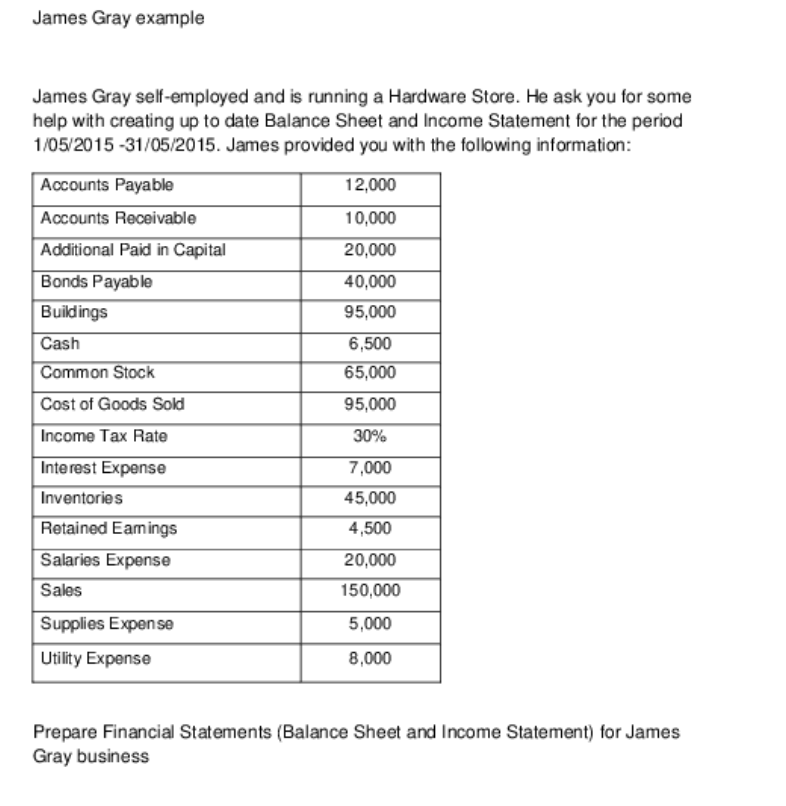

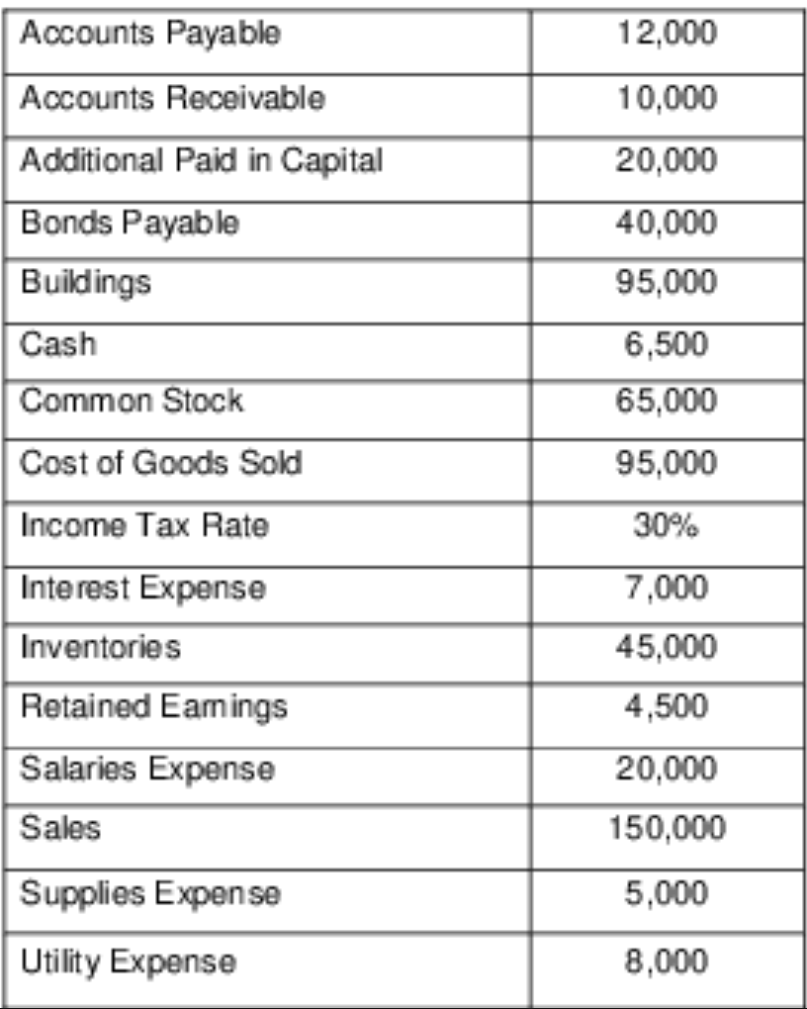

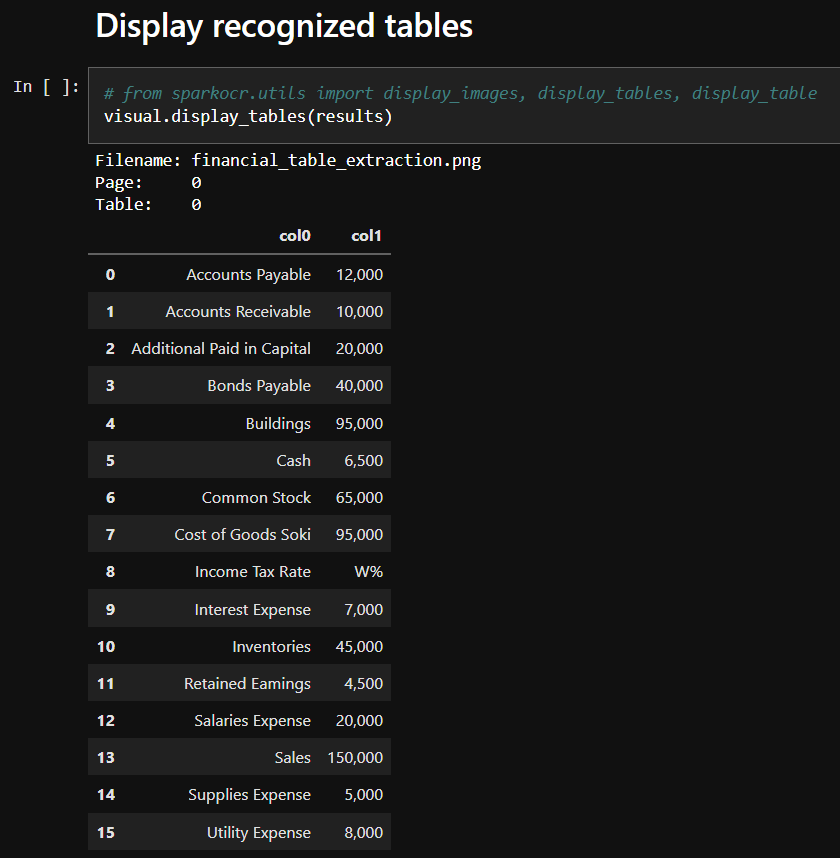